# Sklearn Pipelines
The best way to leverage whole sklearn landscape is to use TSColumnTransformer - it's the hcrystalball implementation of ColumnTransformer which works on pandas dataframes and hcrystalball API, other functionality like pipeline, transformers can be leveraged with TSColumnTransformer directly from sklearn. hcrystalball's own transformers do not need TSColumnTransformer, but might be used with it as well - depending on whether they work on column or index (or both)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 6]

In [2]:
from hcrystalball.wrappers import get_sklearn_wrapper
from hcrystalball.compose import TSColumnTransformer
from hcrystalball.feature_extraction import SeasonalityTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [3]:
from hcrystalball.utils import get_sales_data

df = get_sales_data(n_dates=365*2, 
                    n_assortments=1, 
                    n_states=1, 
                    n_stores=1)
X, y = pd.DataFrame(index=df.index), df['Sales']

## Building pipeline with exogenous variables

In [4]:
# you can use standard sklearn transformations for your exogenous variables
X['trend'] = np.arange(len(X))

In [5]:
# add standard scaler to the trend and let the date column pass in raw form
sklearns_native_transformers = TSColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ['trend'])
    ])    
# define random forest model
rf_model = get_sklearn_wrapper(RandomForestRegressor)
# glue it together
sklearn_model_pipeline = Pipeline([
    ('sklearns_native_transformers', sklearns_native_transformers), 
    ('seasonality', SeasonalityTransformer(auto=True, freq='D')),
    ('model', rf_model)
]) 

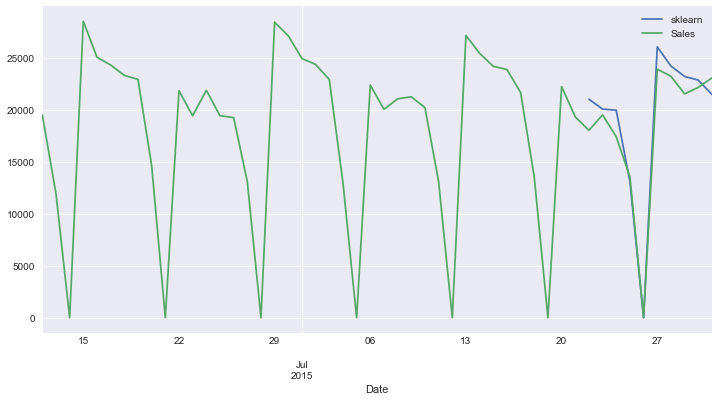

In [6]:
(sklearn_model_pipeline.fit(X[:-10], y[:-10])
                       .predict(X[-10:])
                       .merge(y, left_index=True, right_index=True, how='outer')
                       .tail(50)
                       .plot()
);